In [2]:
## Import all necessary libraries
from src.models.cv import model_run
from src.utils.config import load_config
from src.data.load import load_weekly_sales
import argparse
import pandas as pd
from src.viz.visualize_data import plot_scatter
from src.features.feature_validation import collinearity_test, check_stationary
from src.features.feature_processing import add_thanksgiving_christmas_flags, month_start_flag 
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed
from difflib import get_close_matches
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

### Motivation: In this notebook, exploratory data analysis has been performed. 

### Load the dataset

In [3]:
## Loading parameters from config
args = {"config": "configs/Params_set.yml"}

cfg = load_config(args["config"])


In [4]:
## Load the dataset
df = load_weekly_sales(cfg["data"]["path_file"],
                      cfg["data"]["index_col"],
                      cfg["data"]["target_var"])

# Extract year and month from date
year = df.index.year
month = df.index.month
unique_years = year.unique()

### The dataset contains weekly sales of 45 stores, along with some variables like, holiday information, temperature, fuel price, consumer purchasing index and unemployment.

In [5]:
df.head(10)

,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,y
Date,,,,,,,
2010-02-05,1,0,42.31,2.572,211.096358,8.106,1643690.90
2010-02-12,1,1,38.51,2.548,211.242170,8.106,1641957.44
2010-02-19,1,0,39.93,2.514,211.289143,8.106,1611968.17
2010-02-26,1,0,46.63,2.561,211.319643,8.106,1409727.59
2010-03-05,1,0,46.50,2.625,211.350143,8.106,1554806.68
2010-03-12,1,0,57.79,2.667,211.380643,8.106,1439541.59
2010-03-19,1,0,54.58,2.720,211.215635,8.106,1472515.79
2010-03-26,1,0,51.45,2.732,211.018042,8.106,1404429.92
2010-04-02,1,0,62.27,2.719,210.820450,7.808,1594968.28


In [6]:
##  Missing data check
print(df.isnull().sum())

Store           0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
y               0
dtype: int64


### Boxplot of weekly sales of all the 45 stores, to see if the sales are same or different.

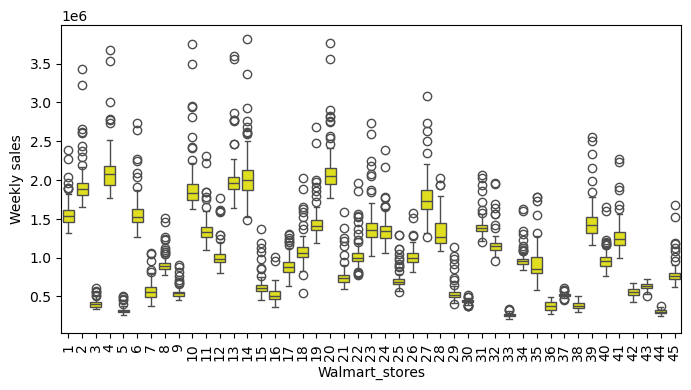

In [7]:
## Weekly sales are different acorss all the stores.
plot_scatter(df, df["Store"], df["y"], "Walmart_stores", "Weekly sales", "", "yellow", (8,4))

In [8]:
## Stastistical confirmation of "sales are different acorss stores"

groups = [grp['y'].values for _, grp in df.groupby('Store')]
f_stat, p_val = f_oneway(*groups)
print(f"F‐statistic: {f_stat:.2f}, p‐value: {p_val:.3f}")

F‐statistic: 1613.30, p‐value: 0.000


In [9]:
## Extract store1 information
df_store = df.loc[df["Store"]==1,]

In [10]:
### checking is the weekly_sales is stationary of not
pval = check_stationary(df_store[["y"]], name = "y")
if pval<=0.05:
    print("Weekly sales is stationery")
else:
    print("Weekly sales is not stationery, it needs differencing")


Weekly sales is stationery


### Identifying seasionality and trend of weekly sales of store1, along with trend of exogenous variables like Fuel Price, Unemployment, Temperature and CPI.

Text(0.5, 1.0, '9) Yearly sales')

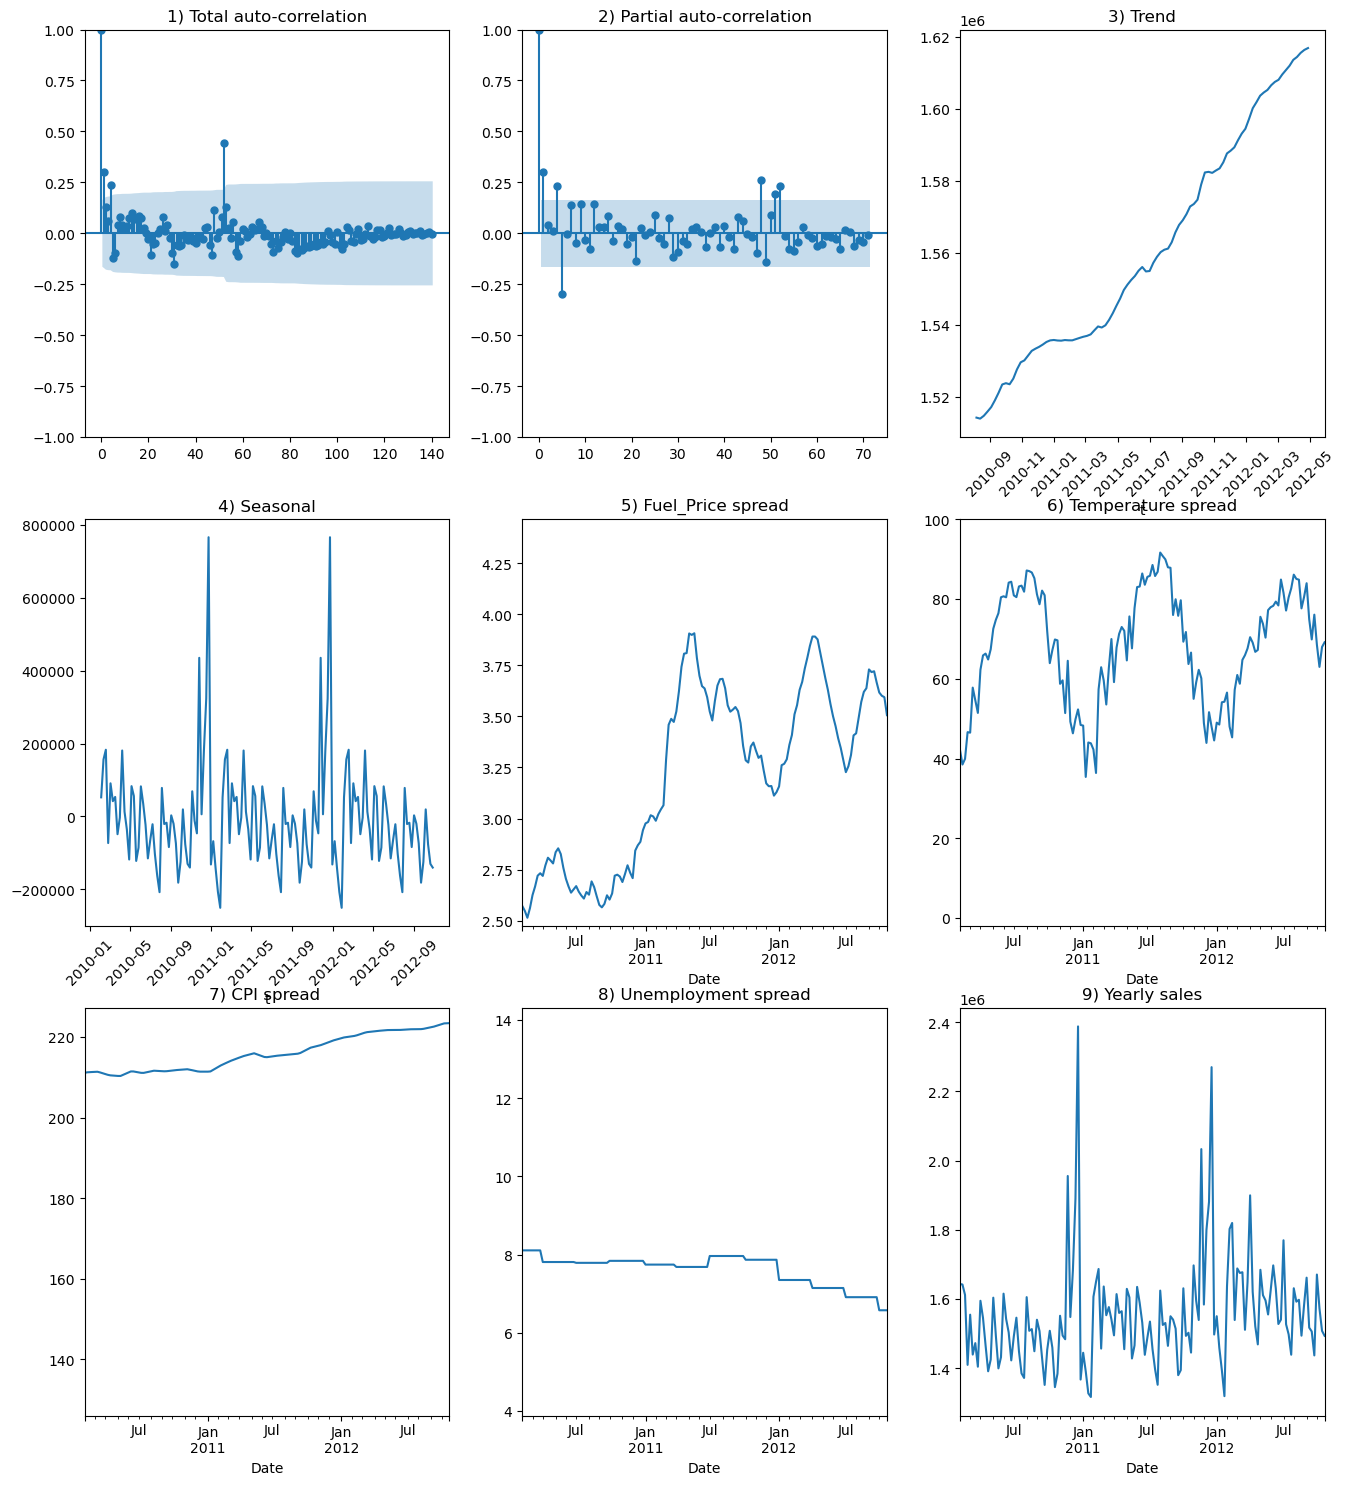

In [19]:

Temp_min, Temp_max = df["Temperature"].min(), df["Temperature"].max()
CPI_min, CPI_max = df["CPI"].min(), df["CPI"].max()
Unemp_min, Unemp_max = df["Unemployment"].min(), df["Unemployment"].max()
FuelPrice_min, FuelPrice_max = df["Fuel_Price"].min(), df["Fuel_Price"].max()


df_store = df.loc[df["Store"]==1,]
 
decomp = seasonal_decompose(df_store['y'], 
                               model= 'additive', period = 52)
        
        
fig,axes = plt.subplots(3,3, figsize=(16, 18))
axes = axes.flatten()
        
plot_acf(df_store['y'], lags = 140, ax = axes[0])
axes[0].set_title("1) Total auto-correlation")
        
plot_pacf(df_store['y'], lags = 71, ax = axes[1])
axes[1].set_title("2) Partial auto-correlation")
        
axes[2].plot(decomp.trend)
axes[2].set_title("3) Trend")
axes[2].set_xlabel("t")
axes[2].tick_params(axis='x', rotation=45) 
        
axes[3].plot(decomp.seasonal)
axes[3].set_title("4) Seasonal")
axes[3].set_xlabel("t")
axes[3].tick_params(axis='x', rotation=45) 
        
        #axes[4].plot(decomp.resid)
        #axes[4].set_title("5) Residual")
        #axes[4].tick_params(axis='x', rotation=90) 
        
df_store["Fuel_Price"].plot.line(ax = axes[4])
axes[4].set_title("5) Fuel_Price spread")
axes[4].set_ylim(FuelPrice_min, FuelPrice_max)       
        
        #df_store["Temperature"].plot.box(ax = axes[5])
df_store["Temperature"].plot.line(ax = axes[5])
axes[5].set_title("6) Temperature spread")
axes[5].set_ylim(Temp_min, Temp_max) 
        
        #df_store["CPI"].plot.box(ax = axes[6])
df_store["CPI"].plot.line(ax = axes[6])
axes[6].set_title("7) CPI spread ")
axes[6].set_ylim(CPI_min,CPI_max)
        
        #df_store["Unemployment"].plot.box(ax = axes[7])
df_store["Unemployment"].plot.line(ax = axes[7])
axes[7].set_title("8) Unemployment spread")
axes[7].set_ylim(Unemp_min, Unemp_max)
        
df_store["y"].plot.line(ax = axes[8])
axes[8].set_title("9) Yearly sales")
        
               
          
       

In [20]:
# Checking if the exogenous variables are collinear,  get the variable with >5 Variance Inflation Factor

collinear_var = collinearity_test(df_store)
print(f"colllinear variable: {collinear_var}")

colllinear variable: CPI


### Conclusion:
### 1. Weekly sales of store1 has strong seasonality with hugh sales during thanksgving and christmas break.
### 2. There is a spike in the sales at the beginning of each month. 
### 3. A slight increasing trend of the sales from year 2010 to 2012. Statistically, the weekly sales is stationary. 
### 4. Temperature has strong seasonal pattern. 
### 5. CPI and Unemployemnt has inverse relationship, where CPI has increasing trend and Unemployment has decreasing trend. 
### 6. Consumer purchasing index has VIF score>5, we will remove it from model training. 

#### Created By: Ruby Sharma